<a href="https://colab.research.google.com/github/kdambrowski/Dice-Face-Recognition/blob/main/Dice_face_recog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project description
The overall goal of the project is to develop the tool that can automatically recognize and count the values of dice based on the photos of six-sided dice. For the recognizing dice and counting the values we build machine learning model.

Dataset used for **training and validating** machine learning model consists of 1 944 images of dice. Captured photos of two different size and color dice.

Image specification:

```markdown
Category          | Detail
------------------|------------------
Image format      | JPG
Size              | 256 x 256
Channel           | 3 (Color)
Depth             | 8

```
Labels specification:
```markdown
Label Dice  | Count
------------|------------------
1           | 324
2           | 324
3           | 324
4           | 324
5           | 324
6           | 324
```
Labels are balanced.

In order to recognize the face of dice and count circles we use image processing utilities and deep learning model.

========================================================================

Dataset used for **testing** machine learning model consists of 2 400 images of dice. Captured photos of two different size and color dice.

Image specification:

```markdown
Category          | Detail
------------------|------------------
Image format      | JPG
Size              | 256 x 256
Channel           | 1 (Color)
Depth             | 8

```
Labels specification:
```markdown
Label Dice  | Count
------------|------------------
1           | 400
2           | 400
3           | 400
4           | 400
5           | 400
6           | 400
```
Labels are balanced.



#Library

In [ ]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 7.5 MB/s 


In [ ]:
!pip install pretty_confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import keras.utils

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.cluster import KMeans
from sklearn import preprocessing
from google.colab.patches import cv2_imshow
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize, OneHotEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Rescaling, Conv2D, MaxPooling2D, Flatten, Dense
from keras_cv.layers import Grayscale
from keras_cv.layers import preprocessing
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle
from pretty_confusion_matrix import pp_matrix_from_data

#Functions

In [ ]:
def color_hist(image):
  """ function to separate each of color's canals and show up histogram"""
  cv2_imshow(image)
  if image.ndim >2:
    """in case when image is coding by BGRA or BGR """
    ax = plt.subplot(311)
    plt.xlim([0,256])
    for i, color in enumerate(['blue','green','red']):
      hist = cv2.calcHist([image], [i], None, [256], [0, 256])
      ax = plt.subplot(3,1,1+i, sharey=ax)
      plt.plot(hist, color=color)
      plt.title(f'histogram for color: {color}')
      if i<2:
        plt.setp(ax.get_xticklabels(), visible=False)
        plt.show()
  else:
    """ in case when color's image are coding by 2 chanels e.g (gray or sepia)"""
    plt.hist(image.ravel(),bins = 256, range=[0,256], color='gray')
    plt.title(f'histogram for color: GRAY or sepia')
    plt.show()

def show_image_after_equalize_colors(image):
  """function for boosting visualisation of image\
  \ this equalize colour histogram"""
  new_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
  H, S, V = cv2.split(new_image)
  eq_V = cv2.equalizeHist(V)
  eq_image = cv2.cvtColor(cv2.merge([H, S, eq_V]), cv2.COLOR_HSV2BGR)
  cv2_imshow(image)
  color_hist(eq_image)

def apply_filter(source, kernel):
  """ applying filter mask on img"""
  new_image = cv2.filter2D(source, -1, kernel)
  return new_image

def scaling_img(image,scale):
  """function for scaling picture"""
  image = image.numpy()
  scale_size = float(scale)
  heigh, weight, color = image.shape
  heigh_scaled = int(heigh*scale_size)
  weight_scaled = int(weight*scale_size)
  picture_dimension = (weight_scaled,heigh_scaled)
  return cv2.resize(image,picture_dimension)

def set_dimension_img(image,heigh,weight):
  """function for set define dimennsion for picture"""
  picture_dimension = (heigh,weight)
  return cv2.resize(image,picture_dimension)

def color_diverse(img):
  """function separate colour for 3 difference chanels"""
  chanels = []
  for i , c in enumerate(['b','g','r']):
    c = img.copy()
    chanels.append(c)
    if i == 0:
      c[:, :, 1] = 0
      c[:, :, 2] = 0
    elif i == 1:
      c[:, :, 0] = 0
      c[:, :, 2] = 0
    else:
      c[:, :, 0] = 0
      c[:, :, 1] = 0
  return chanels

def jpg_file_renamed(folder_path, prefix, sufix_counter=False):
  """Changing name of files in indicated folder, add to regular name prefix
  and is possibility to add sufix_counter on the end of regular name.
  Sufix starts with 0 value
  """
  prefix_str = str(prefix)
  additional_slash = '/'
  folder_path_slash = folder_path + additional_slash
  folder_elements = os.listdir(folder_path_slash)
  if sufix_counter:
    sufix_counter = 0
    for file_name in folder_elements:
      source = folder_path_slash + file_name
      destination = folder_path_slash + prefix+"_" + file_name + str(sufix_counter)
      #result = ....ColoredDiceDataset/1/prefix000108sufix.jpg
      os.rename(source, destination)
      sufix_counter +=1
  else:
    for file_name in folder_elements:
      source = folder_path_slash + file_name
      destination = folder_path_slash + prefix +"_" + file_name
      #result = ....ColoredDiceDataset/1/1000108.jpg
      os.rename(source, destination)
  previous_example_2_eg = folder_elements[:2]
  results_2_eg= os.listdir(folder_path)[:2]
  return print('All files renamed successfully in indicated path',
               f'\nprevious name: {previous_example_2_eg}',
               f'\ncurrent name:{results_2_eg}\n')

def roc_dicts(no_classes, y_test, y_score):
  """ function prepare dictionaries with computed values for prepare ROC curve"""
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  all_fpr = []
  mean_tpr = []

  for i in range(no_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    all_fpr = np.unique(np.concatenate(all_fpr, fpr[i]))
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  mean_tpr /= no_classes
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  return fpr, tpr, roc_auc

def plot_history(history):
    #Plot the Loss Curves
    plt.figure(figsize=[8,6])

    plt.plot(history.history['loss'],'r',linewidth=3.0, marker='o' )
    plt.plot(history.history['val_loss'],'b',linewidth=3.0, marker='+', markersize=12)

    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()

    #Plot the Accuracy Curves
    plt.figure(figsize=[8,6])

    plt.plot(history.history['accuracy'], 'r', linewidth=3.0,  marker='o')
    plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0,  marker='+', markersize=12)

    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.show()

    plt.plot(history.history['loss'][-16:-1],'r',linewidth=3.0, marker='o' )
    plt.plot(history.history['val_loss'][-16:-1],'b',linewidth=3.0, marker='+', markersize=12)

    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Last 15 epochs of loss function',fontsize=16)
    plt.show()

def dir_items_counter(folder_name, dataset_path):
    file_size = []
    for f_name in folder_name:
      """ Checking the length of the objects inside the indicated path """
      indirect_path = dataset_path + "/" + f_name
      file_size.append(len(os.listdir(indirect_path)))
    return file_size


# Dataset download and unpacking


In [ ]:
!git clone https://github.com/tomitomi3/DiceRecognitionDatasetForML/

Cloning into 'DiceRecognitionDatasetForML'...
remote: Enumerating objects: 46, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 46 (delta 2), reused 0 (delta 0), pack-reused 35
Unpacking objects: 100% (46/46), done.


In [ ]:
zip_file_path = '/content/DiceRecognitionDatasetForML/dataset/ColoredDiceDataset.zip'
general_dir='/content/DiceRecognitionDatasetForML/dataset/'


Downloading the training and val data - dice dataset

In [ ]:
!unzip '/content/DiceRecognitionDatasetForML/dataset/ColoredDiceDataset.zip' -d /content/DiceRecognitionDatasetForML/dataset/

Downloading the test data - dice dataset

In [ ]:
!unzip '/content/DiceRecognitionDatasetForML/dataset/DiceDataset.zip' -d /content/DiceRecognitionDatasetForML/dataset_test/

# Preprocessing

setings and var

In [ ]:
coloreddicedataset_path = '/content/DiceRecognitionDatasetForML/dataset/ColoredDiceDataset'
dicedataset_path = '/content/DiceRecognitionDatasetForML/dataset_test/DiceDataset'
upper_path_of_folder = '/content/DiceRecognitionDatasetForML/dataset/ColoredDiceDataset'
seed = 2
batch_size = 64
val_split = 0.2
image_size=(64, 64)

Program

In [ ]:
folder_name = sorted(os.listdir(upper_path_of_folder))
for f_name in folder_name:
  indirect_path = upper_path_of_folder + "/" + f_name
  jpg_file_renamed(indirect_path,f_name)

All files renamed successfully in indicated path 
previous name: ['000279.jpg', '000213.jpg'] 
current name:['1_000139.jpg', '1_000084.jpg']

All files renamed successfully in indicated path 
previous name: ['000279.jpg', '000213.jpg'] 
current name:['2_000240.jpg', '2_000130.jpg']

All files renamed successfully in indicated path 
previous name: ['000279.jpg', '000213.jpg'] 
current name:['3_000100.jpg', '3_000231.jpg']

All files renamed successfully in indicated path 
previous name: ['000279.jpg', '000213.jpg'] 
current name:['4_000164.jpg', '4_000230.jpg']

All files renamed successfully in indicated path 
previous name: ['000279.jpg', '000213.jpg'] 
current name:['5_000310.jpg', '5_000201.jpg']

All files renamed successfully in indicated path 
previous name: ['000279.jpg', '000213.jpg'] 
current name:['6_000312.jpg', '6_000133.jpg']



## Generating dataset
The directory structure looks as follows:
```markdown
main_directory/
 ....class_1/
 ........image001.jpg
 ........image002.jpg
  ....class_2/
 ........image001.jpg
 ........image002.jpg
```
Using tf.keras.utils.image_dataset_from_directory returns batches of images from the subdirectories of classes: {1,2,3,4,5,6}.

In [ ]:
training_ds = tf.keras.utils.image_dataset_from_directory(
    coloreddicedataset_path,
    validation_split = val_split,
    subset='training',
    seed = seed,
    batch_size=batch_size,
    label_mode='int',
)

Found 1944 files belonging to 6 classes.
Using 1556 files for training.


In [ ]:
print(dir_items_counter(folder_name, upper_path_of_folder))
print(sum(dir_items_counter(folder_name, upper_path_of_folder)))

[324, 324, 324, 324, 324, 324]
1944


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    dicedataset_path,
    seed = seed,
    batch_size=batch_size,
    label_mode='int',
)

Found 2400 files belonging to 6 classes.


In [ ]:
print(dir_items_counter(folder_name, dicedataset_path))
print(sum(dir_items_counter(folder_name, dicedataset_path)))

[400, 400, 400, 400, 400, 400]
2400


In [ ]:
test_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
""" This is basic training DS w/o colour change"""
training_ds_small = tf.keras.utils.image_dataset_from_directory(
    coloreddicedataset_path,
    image_size = image_size,
    validation_split = val_split,
    subset='training',
    seed = seed,
    batch_size=batch_size,
    label_mode='categorical',
)

Found 1944 files belonging to 6 classes.
Using 1556 files for training.


In [ ]:
""" This is basic training DS but color scale has been change to gray"""
training_ds_small_gray = tf.keras.utils.image_dataset_from_directory(
    coloreddicedataset_path,
    image_size = image_size,
    color_mode = "grayscale",
    validation_split = val_split,
    subset='training',
    seed = seed,
    batch_size=batch_size,
    label_mode='categorical',
)

Found 1944 files belonging to 6 classes.
Using 1556 files for training.


In [ ]:
training_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
test_ds_small = tf.keras.utils.image_dataset_from_directory(
    dicedataset_path,
    image_size = image_size,
    seed = seed,
    batch_size=batch_size,
    label_mode='categorical',
)

Found 2400 files belonging to 6 classes.


In [ ]:
test_ds_small_gray = tf.keras.utils.image_dataset_from_directory(
    dicedataset_path,
    image_size = image_size,
    seed = seed,
    color_mode = "grayscale",
    batch_size=batch_size,
    label_mode='categorical',
)

Found 2400 files belonging to 6 classes.


In [ ]:
for image_batch, labels_batch in test_ds_small_gray:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
labels_batch[:2]

(64, 64, 64, 1)
(64, 6)


<tf.Tensor: shape=(2, 6), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.]], dtype=float32)>

In [ ]:
for image_batch, labels_batch in training_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
labels_batch[:2]

(64, 256, 256, 3)
(64,)


<tf.Tensor: shape=(2,), dtype=int32, numpy=array([0, 3], dtype=int32)>

In [ ]:
train_class_names = training_ds.class_names
test_class_names = test_ds.class_names
train_class_names, test_class_names

(['1', '2', '3', '4', '5', '6'], ['1', '2', '3', '4', '5', '6'])

In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    coloreddicedataset_path,
    validation_split = val_split,
    subset='validation',
    seed = seed,
    batch_size=batch_size,
    label_mode='categorical',
)

Found 1944 files belonging to 6 classes.
Using 388 files for validation.


In [ ]:
val_ds_small = tf.keras.utils.image_dataset_from_directory(
    coloreddicedataset_path,
    image_size = image_size,
    validation_split = val_split,
    subset='validation',
    seed = seed,
    batch_size=batch_size,
    label_mode='categorical',
)

Found 1944 files belonging to 6 classes.
Using 388 files for validation.


In [ ]:
val_ds_small_gray = tf.keras.utils.image_dataset_from_directory(
    coloreddicedataset_path,
    color_mode = "grayscale",
    image_size = image_size,
    validation_split = val_split,
    subset='validation',
    seed = seed,
    batch_size=batch_size,
    label_mode='categorical',
)

Found 1944 files belonging to 6 classes.
Using 388 files for validation.


In [ ]:
val_class_name = val_ds.class_names
val_class_name

['1', '2', '3', '4', '5', '6']

## Data visualization

## Color Dataset

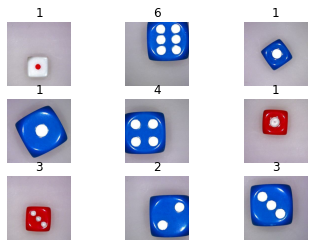

In [ ]:
for images, labels in training_ds.take(1):
  label = labels.numpy()
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_class_names[label[i]])
    plt.axis("off")

## Test Dataset

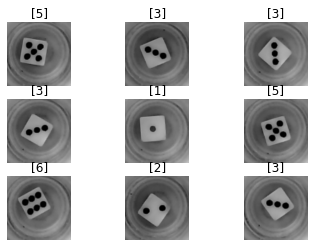

In [ ]:
for images, labels in test_ds_small.take(1):
  index = labels.numpy()
  condition = np.where(index ==1)
  list_condition = condition[1]+1
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title([list_condition[i]])
    plt.axis("off")

## Image transofrmation

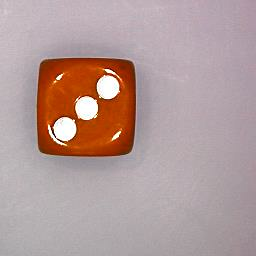

In [ ]:
element = [elements[0][0].numpy() for elements in val_ds.take(1)]
cv2_imshow(element[0])

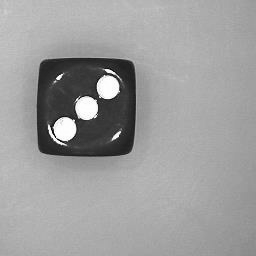

In [ ]:
to_grayscale = preprocessing.Grayscale()
augmented_images = to_grayscale(element[0]).numpy()
cv2_imshow(augmented_images)

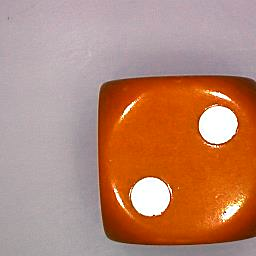

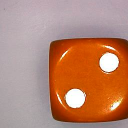

In [ ]:
for images, labels in training_ds.take(1):
  cv2_imshow(images[0].numpy())
  small = scaling_img(images[0],0.5)
  cv2_imshow(small)

# Model


## Model description

Deep learning methods involves training artificial neural networks on described above datasets. The network consists of 10 layers of information processing units (neurons).

Each neuron performs its own simple operation on input from other units and sends its output to other units in subsequent layers until we get an output layer (Dense(num_classes, activation = 'softmax')) with predicted values of dice.

The sequential model consists of three convolution blocks ( tf.keras.layers.Conv2D ) with a maximum pool layer ( tf.keras.layers.MaxPooling2D ) in each of them. There is a fully connected layer ( tf.keras.layers.Dense ) with 128 units on top that is activated by the ReLU activation function ( 'relu' ). This model has been tuned for expected high accuracy.

## Model architecture

## Model for color DS

In [ ]:
num_classes = len(train_class_names)
img_height, img_width = image_size

model = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation = 'softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

## Model for gray DS

In [ ]:
model_gray = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  Conv2D(16, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(32, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Conv2D(64, 3, padding='same', activation='relu'),
  MaxPooling2D(),
  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes, activation = 'softmax')
])

In [ ]:
model_gray.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model_gray.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 1)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)       

## Model fit

## Color model

In [ ]:
history = model.fit(
    training_ds_small,
    epochs=30,
    batch_size=64,
    validation_data=(val_ds_small),
    verbose=1
)

Epoch 1/30
25/25 [==============================] - 8s 293ms/step - loss: 1.7852 - accuracy: 0.1973 - val_loss: 1.7318 - val_accuracy: 0.2655
Epoch 2/30
25/25 [==============================] - 8s 293ms/step - loss: 1.5990 - accuracy: 0.3458 - val_loss: 1.4402 - val_accuracy: 0.3866
Epoch 3/30
25/25 [==============================] - 7s 289ms/step - loss: 1.2149 - accuracy: 0.5090 - val_loss: 1.1166 - val_accuracy: 0.5180
Epoch 4/30
25/25 [==============================] - 7s 289ms/step - loss: 0.8859 - accuracy: 0.6587 - val_loss: 0.8921 - val_accuracy: 0.5902
Epoch 5/30
25/25 [==============================] - 7s 287ms/step - loss: 0.6510 - accuracy: 0.7706 - val_loss: 0.6527 - val_accuracy: 0.7242
Epoch 6/30
25/25 [==============================] - 7s 287ms/step - loss: 0.4691 - accuracy: 0.8323 - val_loss: 0.4927 - val_accuracy: 0.7809
Epoch 7/30
25/25 [==============================] - 7s 282ms/step - loss: 0.3267 - accuracy: 0.8985 - val_loss: 0.4235 - val_accuracy: 0.8402
Epoch 

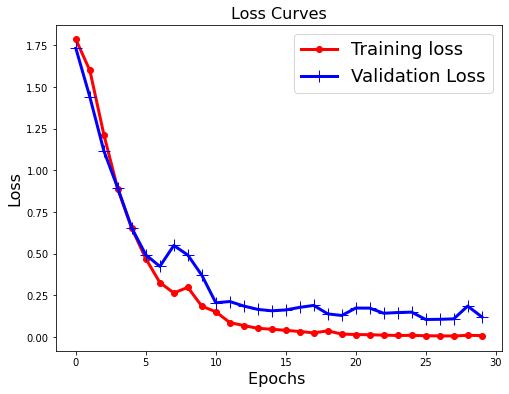

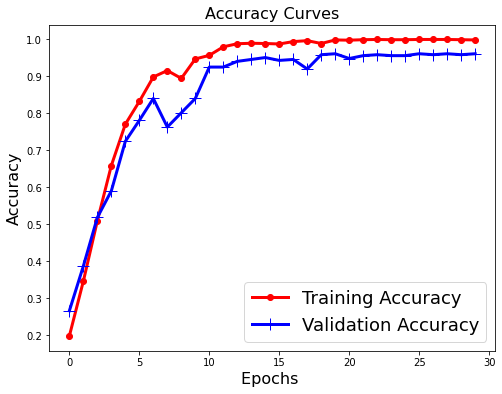

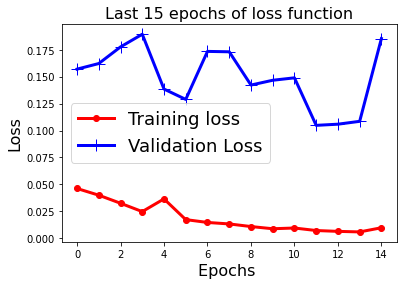

In [ ]:
plot_history(history)

## Gray model

In [ ]:
history_gray = model_gray.fit(
    training_ds_small_gray,
    epochs=30,
    batch_size=64,
    validation_data=(val_ds_small_gray),
    verbose=1
)

Epoch 1/30
25/25 [==============================] - 7s 271ms/step - loss: 1.7731 - accuracy: 0.1973 - val_loss: 1.6963 - val_accuracy: 0.2500
Epoch 2/30
25/25 [==============================] - 7s 264ms/step - loss: 1.5379 - accuracy: 0.3670 - val_loss: 1.3656 - val_accuracy: 0.4149
Epoch 3/30
25/25 [==============================] - 7s 264ms/step - loss: 1.1730 - accuracy: 0.4955 - val_loss: 1.0743 - val_accuracy: 0.5232
Epoch 4/30
25/25 [==============================] - 7s 261ms/step - loss: 0.8776 - accuracy: 0.6465 - val_loss: 0.8465 - val_accuracy: 0.6057
Epoch 5/30
25/25 [==============================] - 7s 260ms/step - loss: 0.6582 - accuracy: 0.7551 - val_loss: 0.7086 - val_accuracy: 0.7191
Epoch 6/30
25/25 [==============================] - 7s 264ms/step - loss: 0.5109 - accuracy: 0.8098 - val_loss: 0.5819 - val_accuracy: 0.7758
Epoch 7/30
25/25 [==============================] - 7s 272ms/step - loss: 0.4063 - accuracy: 0.8663 - val_loss: 0.4440 - val_accuracy: 0.8402
Epoch 

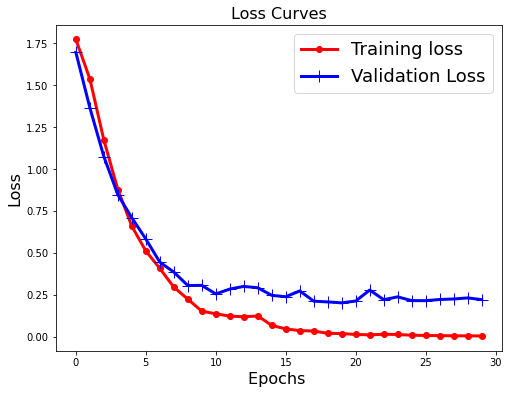

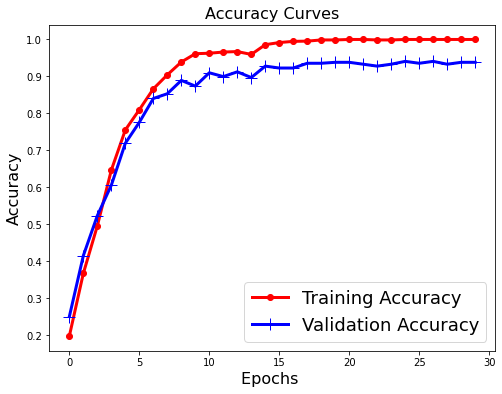

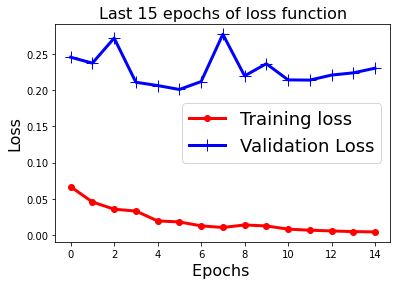

In [ ]:
plot_history(history_gray)

# Model predict

## Color model predict

In [ ]:
prediction = model.predict(test_ds_small)
prediction

38/38 [==============================] - 4s 102ms/step


array([[2.42094267e-02, 9.75069284e-01, 7.02541729e-04, 1.88338217e-05,
        3.92575611e-10, 3.31419365e-15],
       [6.96811080e-01, 2.98602641e-01, 4.57949005e-03, 6.70772897e-06,
        5.34115729e-09, 1.04504416e-15],
       [8.93607199e-01, 1.06313825e-01, 7.85943121e-05, 3.00681023e-07,
        1.01270563e-11, 2.87203561e-17],
       ...,
       [0.00000000e+00, 9.97827289e-28, 3.25997015e-16, 7.09448056e-09,
        2.19596739e-04, 9.99780416e-01],
       [0.00000000e+00, 1.01844697e-27, 5.53993905e-16, 1.35016807e-08,
        7.49533574e-05, 9.99924958e-01],
       [0.00000000e+00, 2.58476801e-29, 1.11461516e-16, 2.03722750e-09,
        6.01797219e-05, 9.99939740e-01]], dtype=float32)

In [ ]:
[test_loss, test_acc] = model.evaluate(test_ds_small)

38/38 [==============================] - 6s 148ms/step - loss: 4.9388 - accuracy: 0.4133


In [ ]:
print(f"Evaluation result on Test Data : Loss = {test_loss:.2f}, accuracy = {test_acc*100:.2f}%")

Evaluation result on Test Data : Loss = 4.94, accuracy = 41.33%


## Gray model

In [ ]:
prediction_gray = model_gray.predict(test_ds_small_gray)

38/38 [==============================] - 4s 98ms/step


In [ ]:
[test_loss, test_acc] = model_gray.evaluate(test_ds_small_gray)
print(f"Evaluation result on Test Data : Loss = {test_loss:.2f}, accuracy = {test_acc*100:.2f}%")

38/38 [==============================] - 4s 98ms/step - loss: 0.5795 - accuracy: 0.7713
Evaluation result on Test Data : Loss = 0.58, accuracy = 77.13%


Conclusion:
After does tests on DS with two different colour scale (color vs gray) Gray scale is better fit to test DS

# Metrics

## ROC curve

## Color model

In [ ]:
prediction = model.predict(val_ds_small)
prediction

In [ ]:
_, acc = model.evaluate(val_ds_small, verbose=1)

7/7 [==============================] - 1s 67ms/step - loss: 0.1211 - accuracy: 0.9613


In [ ]:
label_binarized = np.array([])
for images, labels in val_ds_small:
  labels.numpy()
  label_binarized = np.append(label_binarized, labels)

In [ ]:
label_binarized=label_binarized.reshape(-1,6)

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(test_class_names)):
    fpr[i], tpr[i], _ = roc_curve(label_binarized[:, i], prediction[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(label_binarized.ravel(), prediction.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
roc_auc

{0: 0.5129308124259441,
 1: 0.5178764618000103,
 2: 0.5005111821086261,
 3: 0.48393841911764707,
 4: 0.5790441176470589,
 5: 0.5218948019164391,
 'micro': 0.5224817993410564}

In [ ]:
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(test_class_names))]))
all_fpr.shape

(501,)

In [ ]:
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(test_class_names)):
  mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

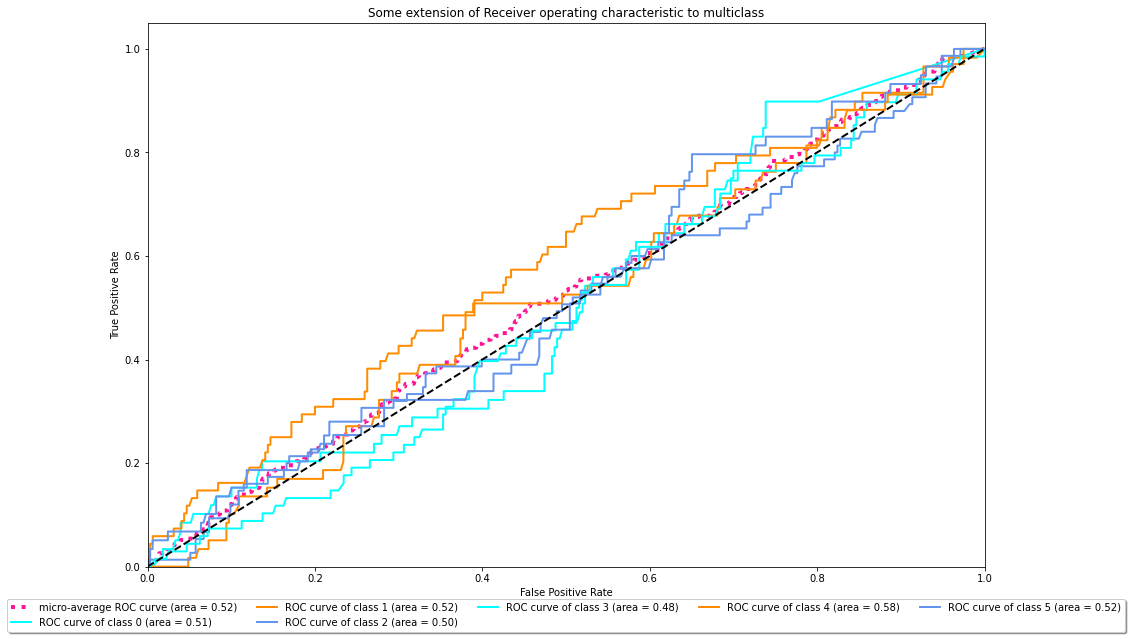

In [ ]:
# Finally average it and compute AUC
mean_tpr /= len(test_class_names)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw = 2
plt.figure(figsize=(15,10))
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(len(test_class_names)), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.show()

## Confusion Matrix

## Color test DS

In [ ]:
y_test = np.array([])
for images, labels in test_ds_small:
  for label in labels:
    y_test = np.append(y_test, (np.argmax(label)).astype(int))

In [ ]:
y_test.shape

(2400,)

In [ ]:
y_prediction = model.predict(test_ds_small)
y_prediction = np.argmax (y_prediction, axis = 1)

38/38 [==============================] - 4s 105ms/step


In [ ]:
confusion_matrix(y_test, y_prediction, labels=None, sample_weight=None, normalize=None)

array([[203,  13, 166,  18,   0,   0],
       [  0, 134,  41,  95, 130,   0],
       [  0,   0, 116,  78, 187,  19],
       [  0,   0,   0, 111,  50, 239],
       [  0,   0,   0,   0,  59, 341],
       [  0,   0,   0,   0,  31, 369]])

In [ ]:
cm = confusion_matrix(y_test, y_prediction, labels=None, sample_weight=None, normalize=None)

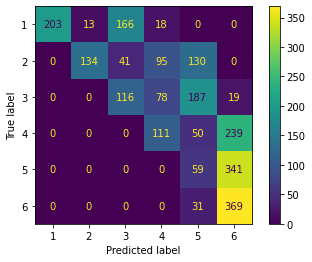

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["1","2","3","4","5","6"])

disp.plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

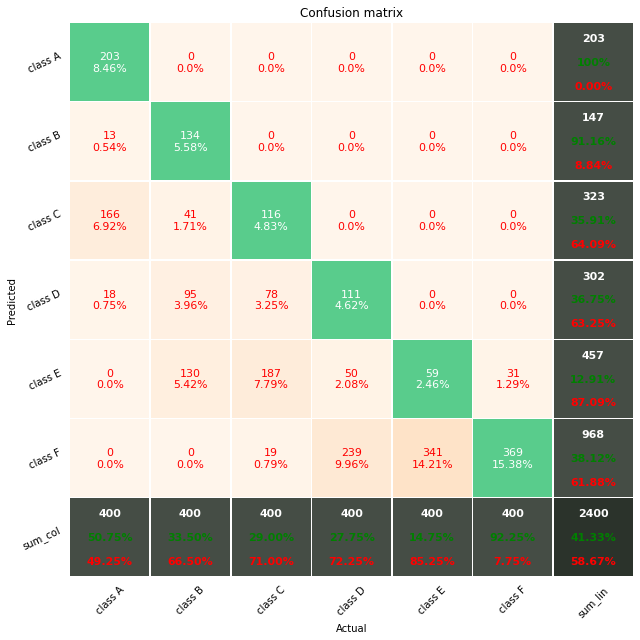

In [ ]:
pp_matrix_from_data(y_test, y_prediction)

## Gray test DS

In [ ]:
y_test_gray = np.array([])
for images, labels in test_ds_small_gray:
  for label in labels:
    y_test_gray = np.append(y_test_gray, (np.argmax(label)).astype(int))


In [ ]:
y_test_gray.shape

(2400,)

In [ ]:
y_prediction_gray = model_gray.predict(test_ds_small_gray)
y_prediction_gray = np.argmax (y_prediction_gray, axis = 1)

38/38 [==============================] - 4s 97ms/step


In [ ]:
confusion_matrix(y_test_gray, y_prediction_gray, labels=None, sample_weight=None, normalize=None)

array([[400,   0,   0,   0,   0,   0],
       [208, 176,  16,   0,   0,   0],
       [  1,  47, 352,   0,   0,   0],
       [  0,   2,  16, 374,   8,   0],
       [  0,   0,   3,  30, 299,  68],
       [  0,   0,  15,  20, 115, 250]])

In [ ]:
cm_gray = confusion_matrix(y_test_gray, y_prediction_gray, labels=None, sample_weight=None, normalize=None)

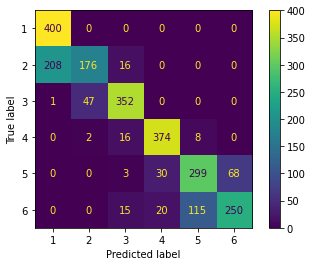

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_gray,
                              display_labels=["1","2","3","4","5","6"])

disp.plot()
plt.show()

/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:200: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:201: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  t.tick2On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:203: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  t.tick1On = False
/usr/local/lib/python3.8/dist-packages/pretty_confusion_matrix/pretty_confusion_matrix.py:204: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be remo

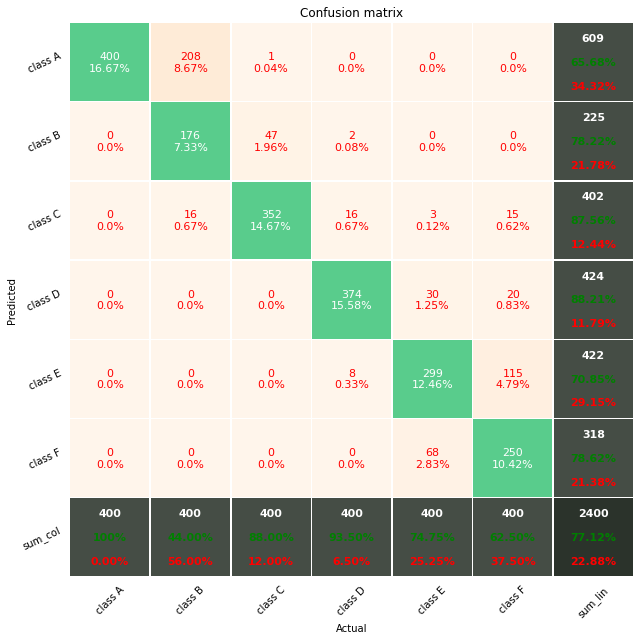

In [ ]:
pp_matrix_from_data(y_test_gray, y_prediction_gray)

#Summary

Prepared model on colored dice achieved **100% acc** on **training** section after **23** epoch but loss function decrease its own value but the decrease level does not improve outputs results.


---


Prepared model achieved on colored dice  **96%** acc on **validation** section after **30** epoch but loss function decrease its own value but the decrease level does not improve outputs results.


---



Prepared model on gray dice achieved **100%**  acc on training section after **21** epoch but loss function decrease its own value but the decrease level does not improve outputs results.


---



Prepared model on gray dice achieved **93% ** acc on va;odatopm section after 30 epoch but loss function decrease its own value but the decrease level does not improve outputs results.



---



predict result on  color model to gray test set:
4s 103ms/step - **loss: 4.9388** - **accuracy: 0.4133**



---



predict result on gray model to gray test set:
4s 99ms/step - **loss: 0.5795 - accuracy: 0.7713**



---



Clolor model have problem with fitted to gray image and results are very randomised.
Model after processed to correct color chanel achieved much better results
Sugetion: input image channels quantity determines which model has to be used.


Error factor analysis:
Confusion matrix for color to gray
Model is the most confident for **recognize 6 and 1 side** on dice and model can predict those values with propability** above acc result 41%**


Confusion matrix for gray to gray:
Model is the most confident for **recognize valuses except 2 and 6 side** on dice and model can predict those values with propability** above acc result 77%**
Side with **2** vales is misstaken with **value 1**
Side with **6** vales is misstaken with **value 5**
**pogrubiony tekst**


for eliminate mentioned problems would be best to do:
- Augumentatnio train images
    - added blur
    - added mask
    - added zoom in/out
    - added rotation
    - recombinate chanel order
    - add rotation on image
- Get more train data